In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.model_selection import KFold
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

In [3]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [4]:
def get_r2(true, prediction):
    u = np.sum((prediction-true)**2)
    v = np.sum((true-np.mean(true))**2)
    return 1 - u / v

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [6]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'super_voxels', 'brain_green_zscore_flat.npy')
brain_vectorized = np.load(brain_path)
print(brain_vectorized.shape)
print_mem()

(482944, 4731)
Current memory usage: 9.77GB


In [7]:
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(77,128,49)

In [8]:
connectivity.shape

(482944, 482944)

In [9]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 62.79 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.29 sec


In [10]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=timestamps,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

In [11]:
for behavior in ['Y', 'Z']:
    fictrac_std = np.std(fictrac[behavior])
    fictrac[behavior] = np.divide(fictrac[behavior],fictrac_std)

In [12]:
Y_glm = fictrac['Y']
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [15]:
clustering_dir = os.path.join(directory, 'super_voxels')
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
n_clusters = [200000,300000,482944,100000,50000,25000,10000,5000,1000,500,100,1]
#n_clusters = [1]
#482944,300000,200000,
#n_clusters = [1000]

out = {}

t00 = time.time()
for cluster in n_clusters[::-1]:
    print('___ {} clusters ___'.format(cluster))
    t0=time.time()
    
    ###############
    ### CLUSTER ###
    ###############
    
    print('clustering...')
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(brain_vectorized)
    
    #################################################
    ### CREATE FEATURES BASED ON CLUSTER AVERAGES ###
    #################################################
    
    print('creating features...')
    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(brain_vectorized[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm = np.asarray(signals).T
    
    ########################
    ### Fit Linear Model ###
    ########################
    
    print('sweeping alphas...')
    out[cluster] = {}
    for alpha in alphas:
        print('alpha: {}. CV_fold: '.format(alpha), end ='')
        t_alpha = time.time()

        out[cluster][alpha] = {}
        train_scores, test_scores, coefs = [], [], []
        
        for j, (train_index, test_index) in enumerate(kf.split(X_glm)):
            print(j, end =' ')

            X_train, X_test = X_glm[train_index], X_glm[test_index]
            Y_train, Y_test = Y_glm[train_index], Y_glm[test_index]

            modelglm = Ridge(alpha=alpha)
            modelglm.fit(X_train, Y_train)
            train_scores.append(modelglm.score(X_train, Y_train))
            test_scores.append(modelglm.score(X_test, Y_test))
            #coefs.append(modelglm.coef_)
        print(' ({:.0f}s)'.format(time.time()-t_alpha))

        out[cluster][alpha]['train'] = np.mean(train_scores)
        out[cluster][alpha]['test'] = np.mean(test_scores)
        #out[cluster][alpha]['coef'] = np.mean(coefs,axis=0)
        
        ############################
        ### Color brain by coefs ###
        ############################
        
#         colored_by_betas = np.zeros(77*128*49)
#         for cluster_num in range(cluster):
#             cluster_indicies = np.where(model.labels_==cluster_num)[0]
#             colored_by_betas[cluster_indicies] = out[cluster][alpha]['coef'][cluster_num]
#         colored_by_betas = colored_by_betas.reshape(77,128,49)

#         out[cluster][alpha]['map'] = colored_by_betas
    
    ############################
    ### Save scores and maps ###
    ############################
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    save_path = os.path.join(clustering_dir, 'models', '{}_ridge_{}.json'.format(timestr, cluster))
    with open(save_path, 'w') as fname:
        json.dump(out, fname)
    print('Saved!')
        
    print('duration {:.0f}s'.format(time.time()-t0))
print('total duration: {:.0f}s'.format(time.time()-t00))

___ 1 clusters ___
clustering...
creating features...
sweeping alphas...
alpha: 1e-06. CV_fold: 0 1 2 3 4  (0s)
alpha: 1e-05. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.0001. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.001. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.01. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.1. CV_fold: 0 1 2 3 4  (0s)
alpha: 1.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 10.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 100.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 1000.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 10000.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 100000.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 1000000.0. CV_fold: 0 1 2 3 4  (0s)
Saved!
duration 26s
___ 100 clusters ___
clustering...
creating features...
sweeping alphas...
alpha: 1e-06. CV_fold: 0 1 2 3 4  (0s)
alpha: 1e-05. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.0001. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.001. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.01. CV_fold: 0 1 2 3 4  (0s)
alpha: 0.1. CV_fold: 0 1 2 3 4  (0s)
alpha: 1.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 10.0. CV_fold: 0 1 2 3 4  (0s)
alpha: 100.0.

### Ran above overnight for alpha sweeps over each n_cluster. Load and continue here.

In [14]:
clustering_dir = os.path.join(directory, 'super_voxels')
to_load = os.path.join(clustering_dir, 'models')
os.listdir(to_load)

['20200609-184246_elasticnet_100000.json',
 '20200608-193937_10000.json',
 '20200609-165746_elasticnet_25000.json',
 '20200609-164959_ridge_100000.json',
 '20200605_lasso_ward.json',
 '20200610-062554_elasticnet_200000.json',
 '20200609-163731_elasticnet_10000.json',
 '20200609-163633_ridge_50000.json',
 '20200610-035439_elasticnet_300000.json',
 '20200604_lasso_complete.json',
 '20200605_ridge_wardcc.json',
 '20200608-200138_25000.json',
 '20200609-194840_ridge_200000.json',
 '20200609-173328_elasticnet_50000.json',
 '20200609-162113_ridge_1000.json',
 '20200609-162313_elasticnet_500.json',
 '20200608-215201_100000.json',
 '20200609-064443_300000.json',
 '20200608-193110_500.json',
 '20200609-032832_482944.json',
 '20200604_lasso_single.json',
 '20200609-191552_ridge_300000.json',
 '20200605_lasso_wardcc.json',
 '20200604_elasticnet_wardcc.json',
 '20200609-162412_elasticnet_1000.json',
 '20200610-003041_elasticnet_482944.json',
 '20200609-162501_ridge_10000.json',
 '20200609-162204_e

In [15]:
to_load = os.path.join(clustering_dir, 'models', '20200609-191552_ridge_300000.json')
with open(to_load) as json_file:
    scores_ridge = json.load(json_file)
    
to_load = os.path.join(clustering_dir, 'models', '20200610-035439_elasticnet_300000.json')
with open(to_load) as json_file:
    scores_elastic = json.load(json_file)
    
to_load = os.path.join(clustering_dir, 'models', '20200609-064443_300000.json')
with open(to_load) as json_file:
    scores_lasso = json.load(json_file)

In [47]:
best_r2s = []
best_alpha = []
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
n_clusters = [482944,300000,100000,50000,25000,10000,5000,1000,500,100,1]
for cluster in n_clusters:
    r2s = [scores_elastic[str(cluster)][str(x)]['test'] for x in alphas]
    best_r2s.append(np.max(r2s))
    best_alpha.append(alphas[np.argmax(r2s)])

In [32]:
best_alpha

[1000000.0,
 1000000.0,
 100000.0,
 10000.0,
 10000.0,
 1000.0,
 1000.0,
 100.0,
 10.0,
 0.01,
 0.1]

In [35]:
best_r2s

[0.49647808571668567,
 0.47890623405202454,
 0.5448649936529002,
 0.5377542860566203,
 0.5901082581514376,
 0.5885272536277811,
 0.6135692379357984,
 0.6255347024299488,
 0.6256096168663069,
 0.5697047878848023,
 0.31106267179344343]

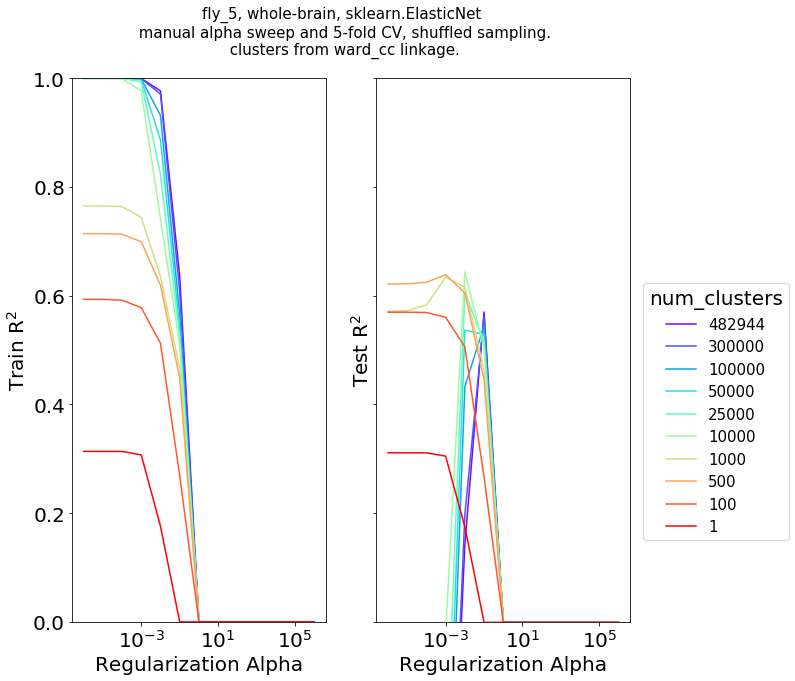

In [25]:
scores = scores_elastic

fig, axs = plt.subplots(1,2, figsize=(10,10), sharey=True)

colors = plt.cm.rainbow(np.linspace(0,1,len(n_clusters)))
for i,cluster in enumerate(n_clusters):
    axs[0].plot([x for x in alphas], [scores[str(cluster)][str(x)]['train'] for x in alphas],'-',label=cluster,color=colors[i])
    
for i,cluster in enumerate(n_clusters):
    axs[1].plot([x for x in alphas], [scores[str(cluster)][str(x)]['test'] for x in alphas],'-',label=cluster,color=colors[i])

axs[0].set_ylabel('Train R$^2$')
axs[1].set_ylabel('Test R$^2$')

for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim(0,1)
    ax.set_xlabel('Regularization Alpha')
    
axs[1].legend(loc=(1.05,.15), title='num_clusters',fontsize=15)
plt.suptitle(x=.5,y=.98,t='fly_5, whole-brain, sklearn.ElasticNet\n manual alpha sweep and 5-fold CV, shuffled sampling.\n clusters from ward_cc linkage.',fontsize=15)


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

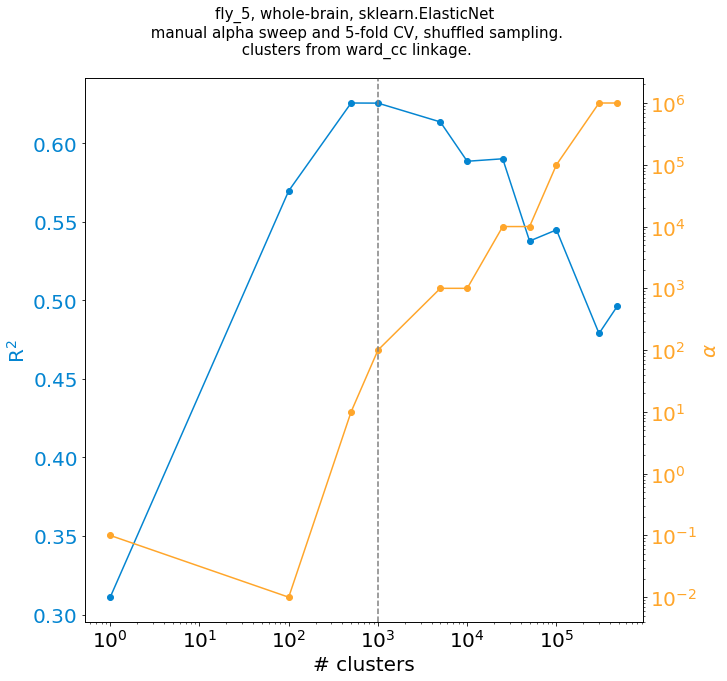

In [34]:
fig, ax1 = plt.subplots(figsize=(10,10))

color = 'xkcd:cerulean'
ax1.set_xlabel('# clusters')
ax1.set_ylabel('R$^2$', color=color)
ax1.plot(n_clusters, best_r2s, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'xkcd:mango'
ax2.set_ylabel('$\\alpha$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(n_clusters, best_alpha, color=color, marker='o')

plt.suptitle(x=.5,y=.98,t='fly_5, whole-brain, sklearn.ElasticNet\n manual alpha sweep and 5-fold CV, shuffled sampling.\n clusters from ward_cc linkage.',fontsize=15)
#plt.text(10000,.099,'max @ 50,000', fontsize=12)
plt.axvline(1000, linestyle='--', color='grey')
plt.xscale('log')
plt.yscale('log')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [37]:
n_clusters

[482944, 300000, 100000, 50000, 25000, 10000, 5000, 1000, 500, 100, 1]

In [86]:
best_alpha

[0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001]

In [50]:
maps = {}
scores = {}

t00 = time.time()
for cluster, alpha in zip(n_clusters[::-1], best_alpha[::-1]):
    print('___ {} clusters ___'.format(cluster))
    t0=time.time()
    
    ###############
    ### CLUSTER ###
    ###############
    
    print('clustering...')
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(brain_vectorized)
    
    #################################################
    ### CREATE FEATURES BASED ON CLUSTER AVERAGES ###
    #################################################
    
    print('creating features...')
    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(brain_vectorized[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm = np.asarray(signals).T
    
    ########################
    ### Fit Linear Model ###
    ########################
    scores[cluster] = {}
    print('CV_fold: '.format(alpha), end ='')    
    t_alpha = time.time()
    train_scores, test_scores, coefs = [], [], []

    for j, (train_index, test_index) in enumerate(kf.split(X_glm)):
        print(j, end =' ')

        X_train, X_test = X_glm[train_index], X_glm[test_index]
        Y_train, Y_test = Y_glm[train_index], Y_glm[test_index]

        modelglm = ElasticNet(alpha=alpha)
        modelglm.fit(X_train, Y_train)
        train_scores.append(modelglm.score(X_train, Y_train))
        test_scores.append(modelglm.score(X_test, Y_test))
        coefs.append(modelglm.coef_)
    print(' ({:.0f}s)'.format(time.time()-t_alpha))

    scores[cluster]['train'] = np.mean(train_scores)
    scores[cluster]['test'] = np.mean(test_scores)
    scores[cluster]['coef'] = np.mean(coefs,axis=0)

    ############################
    ### Color brain by coefs ###
    ############################

    colored_by_betas = np.zeros(77*128*49)
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = scores[cluster]['coef'][cluster_num]
    colored_by_betas = colored_by_betas.reshape(77,128,49)

    maps[cluster] = colored_by_betas
    
    ############################
    ### Save scores and maps ###
    ############################
    
#     timestr = time.strftime("%Y%m%d-%H%M%S")
#     save_path = os.path.join(clustering_dir, 'models', '{}_{}.json'.format(timestr, cluster))
#     with open(save_path, 'w') as fname:
#         json.dump(out, fname)
#     print('Saved!')
        
    print('duration {:.0f}s'.format(time.time()-t0))
print('total duration: {:.0f}s'.format(time.time()-t00))

___ 1 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (0s)
duration 27s
___ 100 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (1s)
duration 25s
___ 500 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (3s)
duration 27s
___ 1000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (7s)
duration 30s
___ 5000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (19s)
duration 46s
___ 10000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (65s)
duration 95s
___ 25000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (197s)
duration 236s
___ 50000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (393s)
duration 448s
___ 100000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (144s)
duration 227s
___ 300000 clusters ___
clustering...
creating features...
CV_fold: 0 1 2 3 4  (623s)
duration 819s
___ 482944 clusters ___
clustering

In [39]:
len(n_clusters)

11

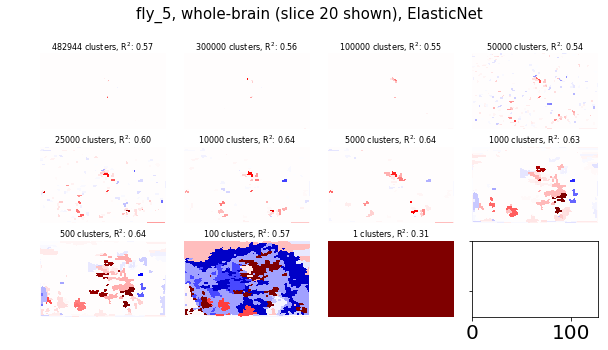

In [52]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.25)
#n_clusters = [9856, 1000]
for i,cluster in enumerate(n_clusters):
    grid[i].imshow(maps[cluster][:,:,20], cmap='seismic', vmin=-np.max(maps[cluster]), vmax=np.max(maps[cluster]))
    grid[i].axis('off')
    grid[i].set_title('{} clusters, R$^2$: {:.2f}'.format(cluster, scores[cluster]['test']),
                      fontsize=8,
                      x=.5,y=1.1,
                      horizontalalignment='center',
                      verticalalignment='top')
plt.suptitle(x=.5,y=.75,t='fly_5, whole-brain (slice 20 shown), ElasticNet',fontsize=15)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

482944
300000
100000
50000
25000
10000
5000
1000
500
100
1


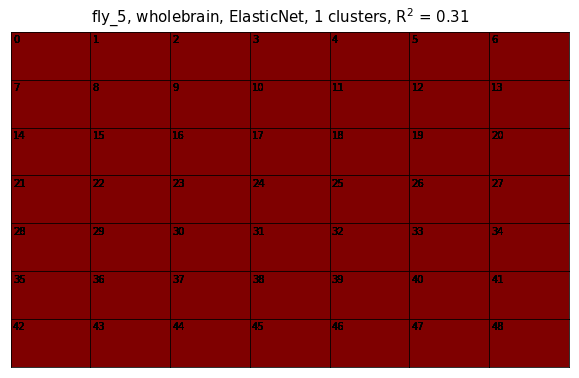

In [53]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=0)
#n_clusters = [9856, 1000]
for cluster in n_clusters:
    print(cluster)

    vmax = np.max(maps[cluster])
    vmin = -vmax

    for i in range(49):
        grid[i].imshow(maps[cluster][:,:,i], cmap='seismic', vmin=vmin, vmax=vmax)
        grid[i].set_xticks([])
        grid[i].set_yticks([]) 
        grid[i].text(x=3,y=4,s=i,fontsize=10,va='top')

    plt.suptitle(x=.5,y=.77,t='fly_5, wholebrain, ElasticNet, {} clusters, R$^2$ = {:0.2f}'.format(cluster, scores[cluster]['test']),fontsize=15)
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, timestr)
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
#     grid[i].set_title('{} clusters, R$^2$: {:.2f}'.format(cluster, scores[cluster]['test']),
#                       fontsize=8,
#                       x=.5,y=1.1,
#                       horizontalalignment='center',
#                       verticalalignment='top')

# ax_cbar=fig.add_axes([.95,.25,.02,.5])
# ax_cbar.plot()
# sm = plt.cm.ScalarMappable(cmap='seismic', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm, cax=ax_cbar)

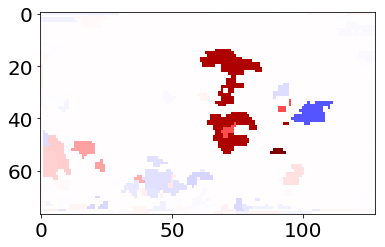

In [39]:
vmin = -np.max(out[1000][0.001]['map'])
vmax = -vmin

plt.imshow(out[1000][0.001]['map'][:,:,14],cmap='seismic',vmin=vmin, vmax=vmax)

In [23]:
[out[1000][i]['test'] for i in alphas]

[0.5913885091681361,
 0.6506440413440855,
 0.5955613988829539,
 0.37112919833266644,
 -0.0008108151419883747,
 -0.0008108151419883747,
 -0.0008108151419883747,
 -0.0008108151419883747,
 -0.0008108151419883747,
 -0.0008108151419883747,
 -0.0008108151419883747]

In [38]:
clustering_dir = os.path.join(directory, 'super_voxels')

t0 = time.time()
model = AgglomerativeClustering(n_clusters = 200000,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(brain_vectorized)
print(time.time()-t0)

180.8541295528412


In [39]:
brain_clusters = model.labels_.reshape(77,128,49)

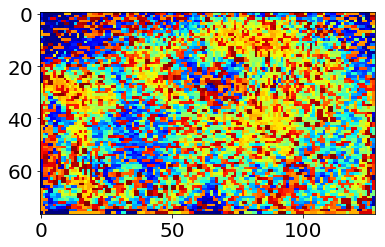

In [40]:
plt.imshow(brain_clusters[:,:,20],cmap='jet')

In [158]:
clustering_dir = os.path.join(directory, 'super_voxels')

brain_cluster_sweep = {}

n_clusters = [200000,100000,50000,20000,10000,5000,1000]
n_clusters = [10000]

for clusters in n_clusters[::-1]:
    print('working on {} clusters'.format(clusters))
    t0 = time.time()
    model = AgglomerativeClustering(n_clusters = clusters,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(brain_vectorized)
    
    brain_clusters = model.labels_.reshape(77,128,49)
    brain_cluster_sweep[clusters] = brain_clusters
    
    save_path = os.path.join(clustering_dir, 'ward_cc_{}'.format(n_clusters))
    np.save(save_path, brain_clusters)
    print(time.time()-t0)

working on 10000 clusters
21.717082023620605


In [46]:
brain_cluster_sweep.keys()

dict_keys([1000, 5000, 10000, 20000, 50000, 100000, 200000])

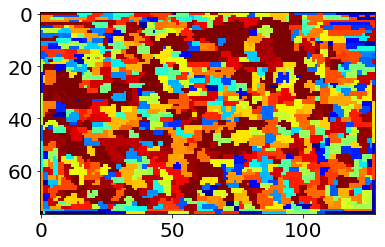

In [172]:
plt.imshow(brain_cluster_sweep[10000][:,:,20],cmap='jet')

In [12]:
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]

In [ ]:
cluster_signals = {}

In [ ]:
clustering_dir = os.path.join(directory, 'super_voxels')
n_clusters = [482944,400000,350000,300000,250000,200000,150000,100000,75000,50000,25000,10000,1000,500,100,1]
cluster_signals = {}

for cluster in n_clusters:
    print('working on cluster {}'.format(cluster))
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(brain_vectorized)

    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(brain_vectorized[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm=np.asarray(signals).T
    
    cluster_signals[cluster] = X_glm

working on cluster 482944
working on cluster 400000
